In [2]:
import torch
import matplotlib.pyplot as plt

from source import gridMA, PlaneSampler, phi_n_star, wold_w_q_fast, wold_w_h_fast, I

# Simulationsstudien von dem Testverfahren
Wir werden uns die Güte des Testverfahrens für 3 verschiedene Prozesse anschauen: MA, Quarterplane und Halfplane.

#### Verhalten unter $H_0$
- $MA$
- $AR$

#### Verhalten unter $H_1$
$MA$:
- Zeile vs Spalte
- $MA(1)$ vs $MA(2)$ 
- Mit und ohne Korrelation
  
$AR$:
- Winkel verschieben (`delta`)
- Schärfe verstellen (`diag`)
- Half plane vs Quarter plane

## Simulationen unter $H_0$
### $MA$
Wir werden einmal den Zeilen MA und den vollen MA vergleichen. Die Koeffizienten von beiden sehen dabei so aus:

$$
K_{ROW} = \begin{pmatrix}
0 & 0 & 0\\
.7 & 1 & .7\\
0 &  0 &0
\end{pmatrix}

K_{FULL} = \begin{pmatrix}
.7 & .7 & .7\\
.7 & 1 & .7\\
.7 &  .7 &.7
\end{pmatrix}
$$

In [3]:
K_ROW = torch.full((3, 3), 0)
K_ROW[1,:] = .7
K_ROW[1,1] = 1

K_FULL = torch.full((3,3), .7)
K_FULL[1,1] = 1

def monte_carlo_under_h0_bandwidth(N, hs, sampler, grid_size):
  rejected_h0 = []
  for h in hs:
    x = sampler(grid_size, grid_size, N)
    y = sampler(grid_size, grid_size, N)
    phi_n_star_monte_carlo = torch.vmap(lambda x, y: phi_n_star(x, y, 100, .05, hr = h, hc = h),
                                        randomness = "different")
    decision, _, _ = phi_n_star_monte_carlo(x[:, 0], y[:, 0])
    rejected_h0.append(decision.sum() / N)
  return rejected_h0

In [4]:
# Config
N = 500
H_STEPS = 20
GRID_SIZE = 20

# samplers
sampler_row = gridMA(K_ROW)
sampler_full = gridMA(K_FULL)

# Bandwith of BP Kernel matters for the (true) size of the test
hs = torch.linspace(0.05, .5, 20)

rej_row = monte_carlo_under_h0_bandwidth(N, hs, sampler_row, GRID_SIZE)
rej_full = monte_carlo_under_h0_bandwidth(N, hs, sampler_full, GRID_SIZE)

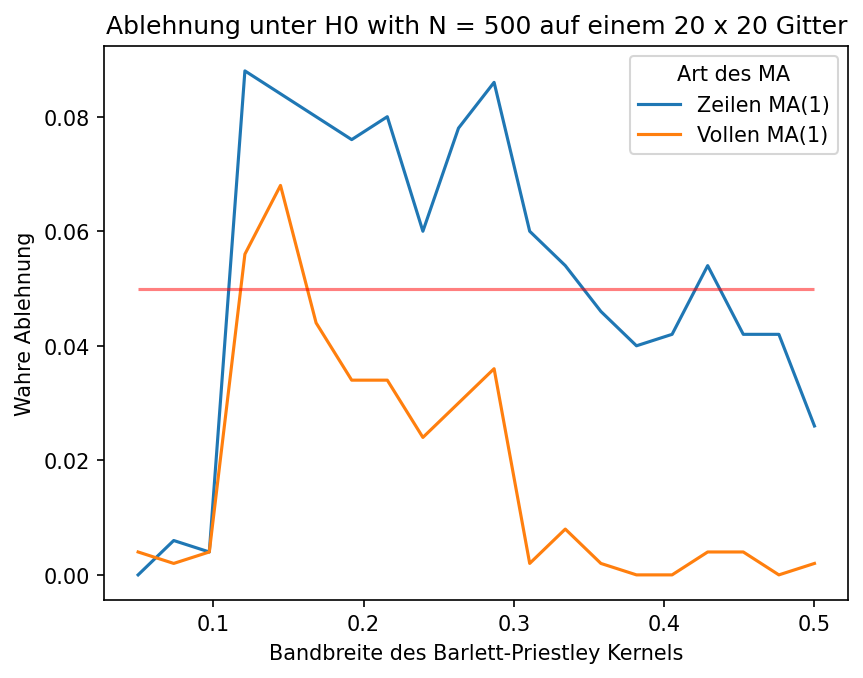

In [6]:
plt.figure(dpi = 150)
plt.plot(hs, rej_row, label = "Zeilen MA(1)")
plt.plot(hs, rej_full, label = "Vollen MA(1)")
plt.title("Ablehnung unter H0 with N = 500 auf einem 20 x 20 Gitter")
plt.xlabel("Bandbreite des Barlett-Priestley Kernels")
plt.ylabel("Wahre Ablehnung")
plt.hlines([.05], .05, .5, colors = ["red"], alpha = .5)
plt.legend(title = "Art des MA")
plt.show()

- Unter sehr kleinen Bandbreiten, ist der Kernel kleiner als die Differenz der Fourier-Frequenzen. Tauschen macht dann keinen Unterschied mehr und alle (sowohl die bedingte als auch die unbedingte) Teststatistiken sind gleich
- Sobald die Kernelbreite ausreicht, um 5 Beobachtungen zu glätten (Bandbreite erreicht die Umliegenden Beobachtungen), schießt die Ablehnung nach oben.
  - Der Test ist jetzt sehr sensibel gegenüber Unterschieden der Spektraldichten
- Je mehr Beobachtungen geglättet werden, desto weniger unterscheidet sich die bedingte Teststatistik von der unbedingten
  - Die Varianz der bedingten Teststatistik wird kleiner und kleiner und der Test lehnt immer weniger ab.
- Generell ist die Ablehnung unter einem vollen $MA(1)$ Prozess kleiner als bei dem Zeilen $MA(1)$

### $AR(1)$
Untersucht wird der Prozess:

$$
X_{ij} = \phi_1 X_{i,j-1} + \phi_2 X_{i-1, j-1} + \phi_3 X_{i-1, j} + \epsilon_{ij}
$$
- $\phi = (\phi_1, \phi_2, \phi_3) = (.8, .08, .1)$

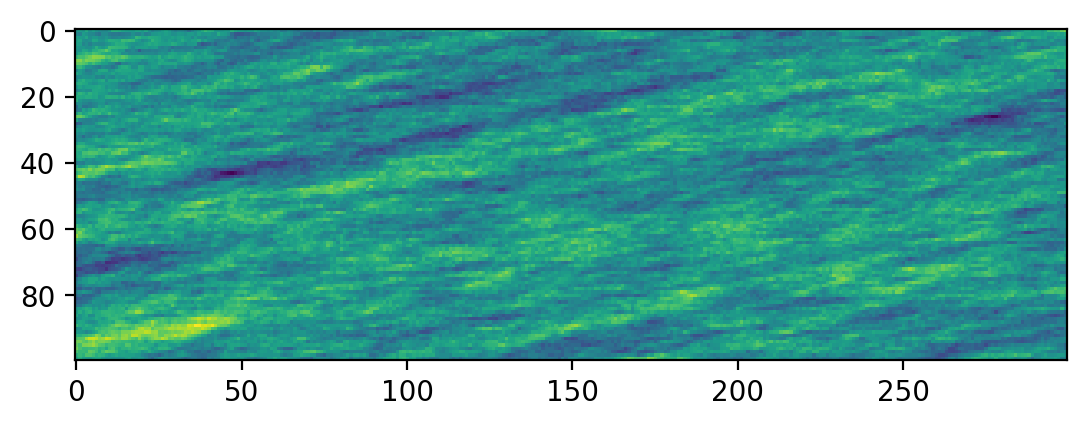

In [6]:
sampler_quarter = PlaneSampler(80, .8, .08, .1)
figure = plt.figure(dpi=200)
plt.imshow(sampler_quarter(100, 300)[0][0])

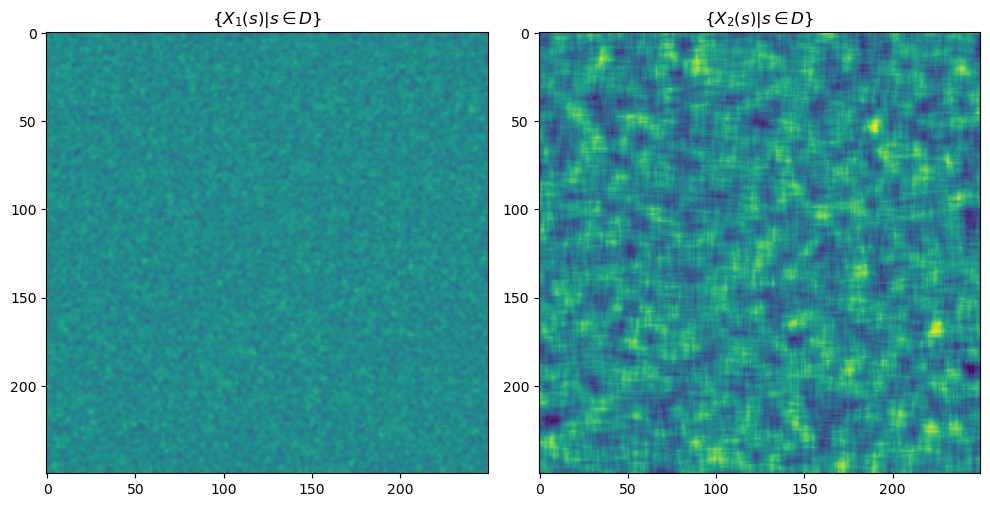

In [4]:
K = torch.full((3, 3), .7)
K[1,1] = 1
sampler_ma = gridMA(K)
img1 = sampler_ma(250, 250)[0][0]

K1 = torch.full((9,9), .7)
K1[5,5] = 1
sampler_ma_1 = gridMA(K1)
img2 = sampler_ma_1(250, 250)[0][0]

# Ensure the same color scale for comparability
vmin = min(img1.min(), img2.min())
vmax = max(img1.max(), img2.max())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1, vmin=vmin, vmax=vmax)
axes[0].set_title(r"$\{X_1(s)| s\in D\}$")

axes[1].imshow(img2, vmin=vmin, vmax=vmax)
axes[1].set_title(r"$\{X_2(s)| s\in D\}$")

plt.tight_layout()
plt.show()

In [8]:
rej_quarter = monte_carlo_under_h0_bandwidth(500, hs, sampler_quarter, 20)

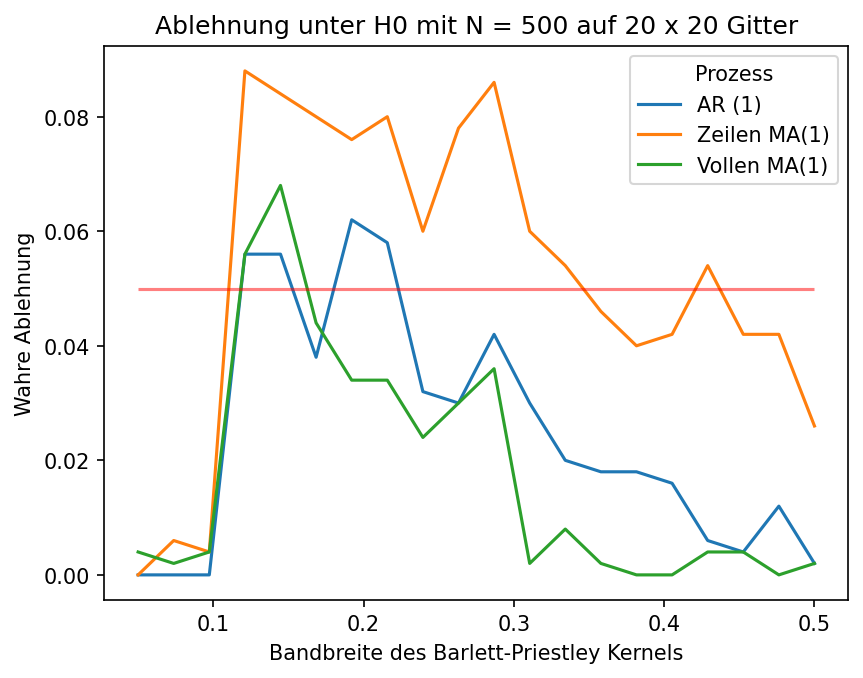

In [9]:
plt.figure(dpi = 150)
plt.plot(hs, rej_quarter, label ="AR (1)")
plt.plot(hs, rej_row, label = "Zeilen MA(1)")
plt.plot(hs, rej_full, label = "Vollen MA(1)")
plt.title("Ablehnung unter H0 mit N = 500 auf 20 x 20 Gitter")
plt.ylabel("Wahre Ablehnung")
plt.hlines([.05], .05, .5, colors = ["red"], alpha = .5)
plt.legend(title="Prozess")
plt.xlabel("Bandbreite des Barlett-Priestley Kernels")
plt.show()

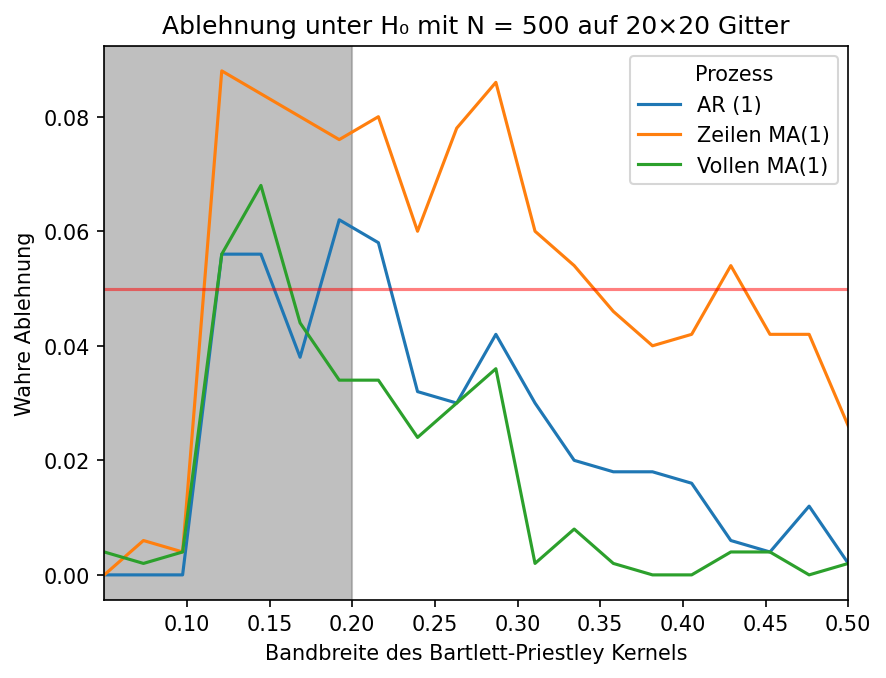

In [19]:
fig, ax = plt.subplots(dpi=150)

# 1) plot your processes as usual
ax.plot(hs, rej_quarter, label="AR (1)")
ax.plot(hs, rej_row,     label="Zeilen MA(1)")
ax.plot(hs, rej_full,    label="Vollen MA(1)")

# 2) shade the region of interest on the x–axis
ax.axvspan(0.05, 0.2,   # from x=0.05 to x=0.10
           color="gray",
           alpha=0.5,    # make it subtle
           zorder=0)     # behind the lines

# ax.axvspan(0.2, 0.5,   # from x=0.05 to x=0.10
#            color="gray",
#            alpha=0.5,    # make it subtle
#            zorder=0)     # behind the lines

# (optional) draw boundary lines instead of, or in addition to, shading
# ax.axvline(0.05, linestyle="--", color="gray", alpha=0.5)
# ax.axvline(0., linestyle="--", color="gray", alpha=0.5)

# 3) rest of your formatting
ax.set_title("Ablehnung unter H₀ mit N = 500 auf 20×20 Gitter")
ax.set_xlabel("Bandbreite des Bartlett-Priestley Kernels")
ax.set_ylabel("Wahre Ablehnung")
ax.hlines(0.05, hs.min(), hs.max(), colors="red", alpha=0.5)
ax.legend(title="Prozess")
ax.set_xlim(hs.min(), hs.max())

plt.show()


In [29]:
def spin(delta, diag):
  sampler = PlaneSampler(40, delta, diag, 0.9-delta)
  sampler.plot()

In [30]:
def quarter_to_half(delta):
  sampler = PlaneSampler(40, .3, .4-.5*delta, 0.3-delta, delta)
  sampler.plot()

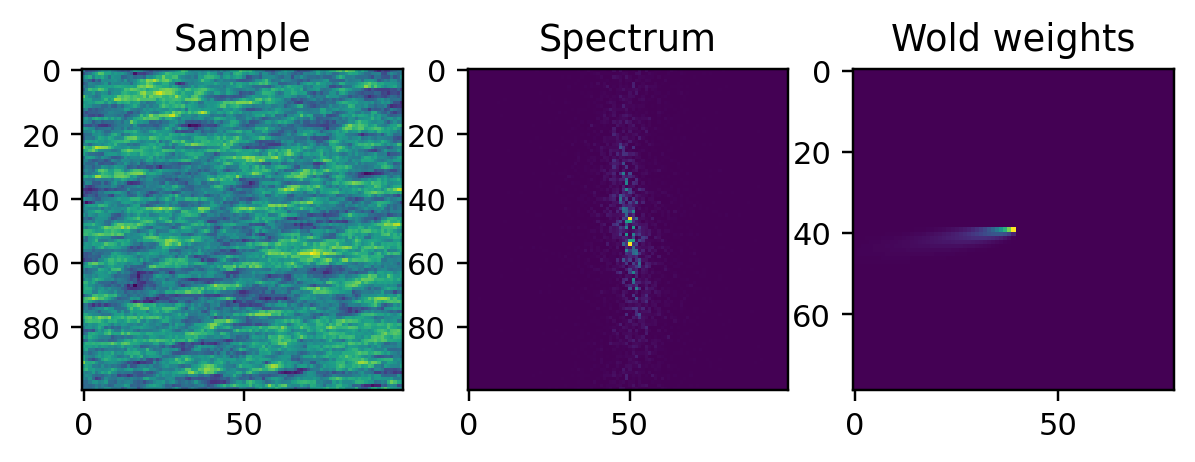

In [49]:
spin(0.8, .03)

### Analysis of Power

In [59]:
# we are going to abstract away most of the simulation code, such that we can focus on the alternative
def power_sim(sampler0, h1_generator, deltas, N = 200, grid_sizes = [20, 25, 30, 40, 50]):
    rejected = torch.zeros(5, 20)
    i = 0
    for grid_size in grid_sizes:
        h = grid_size**(-.4)
        phi_n_star_monte_carlo = torch.vmap(lambda x, y: phi_n_star(x, y, 100, .05, hr = h, hc = h),
                                    randomness="different")
        j = 0
        for delta in deltas:
            sampler1 = h1_generator(delta)
            x = sampler1(grid_size, grid_size, N)
            y = sampler0(grid_size, grid_size, N)
            decision, _, _ = phi_n_star_monte_carlo(x[:, 0], y[:, 0])
            rejected[i, j] = decision.sum() / N
            j += 1
        i += 1
    return rejected

In [23]:
def plot_power_result(rejected, deltas, grid_sizes = [20, 25, 30, 40, 50]):
  plt.figure(dpi = 150)
  for i in range(rejected.shape[0]):
      plt.plot(deltas, rejected[i], label = f"{grid_sizes[i]} x {grid_sizes[i]}")
  plt.title("Güte des Tests für N = 200")
  plt.legend(title ="Gittergröße")
  plt.ylabel("Geschätzte Güte")
  plt.xlabel("delta")
  plt.show()

In [22]:
K0 = torch.full((3,3),.7)
K0[1,1] = 1

sampler0 = gridMA(K0)

def blur_h1_gen(delta):
  K1 = torch.full((7,7), delta)
  K1[3:6, 3:6] = K0
  return gridMA(K1)

deltas = torch.linspace(0, .7, 20)

rej_h1_ma_full = power_sim(sampler0, blur_h1_gen, deltas)

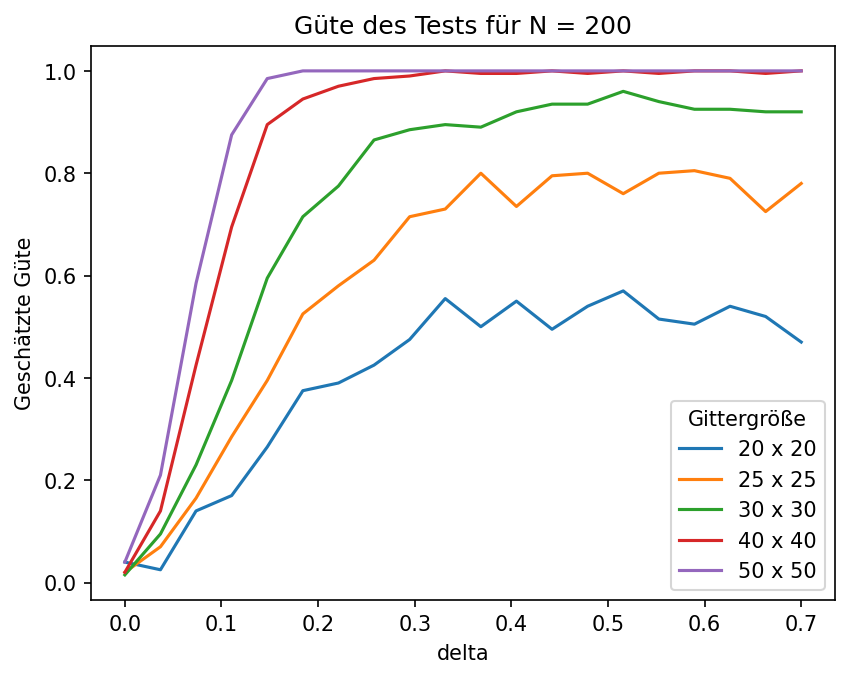

In [24]:
plot_power_result(rej_h1_ma_full, deltas)

In [60]:
def spin_gen(delta, diag = .03):
  sampler = PlaneSampler(40, .1 + delta, diag, 0.8-delta)
  return sampler

sampler_AR0 = spin_gen(0.0)

rej_h1_AR_spin = power_sim(sampler_AR0, spin_gen, deltas)

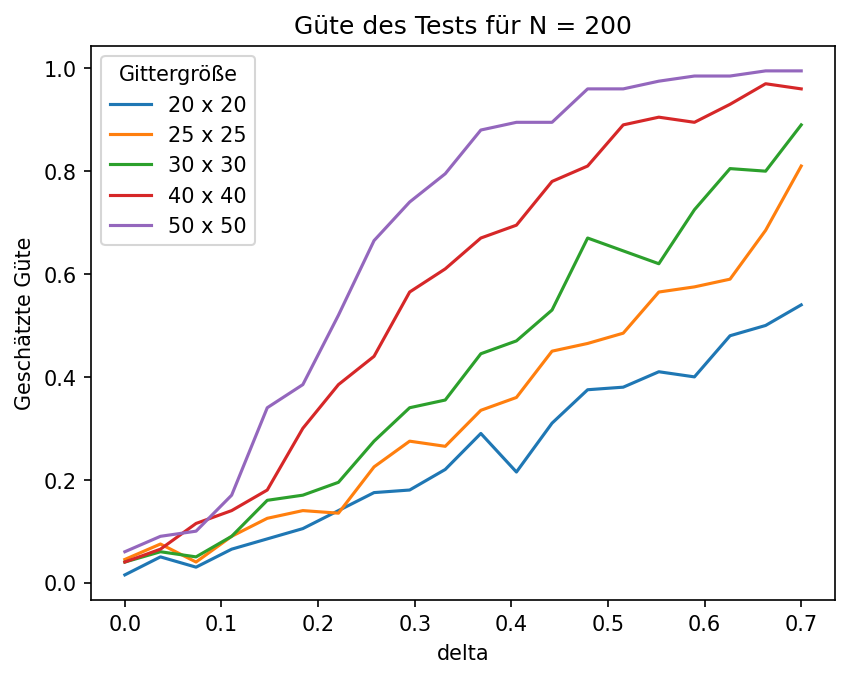

In [61]:
plot_power_result(rej_h1_AR_spin, deltas)

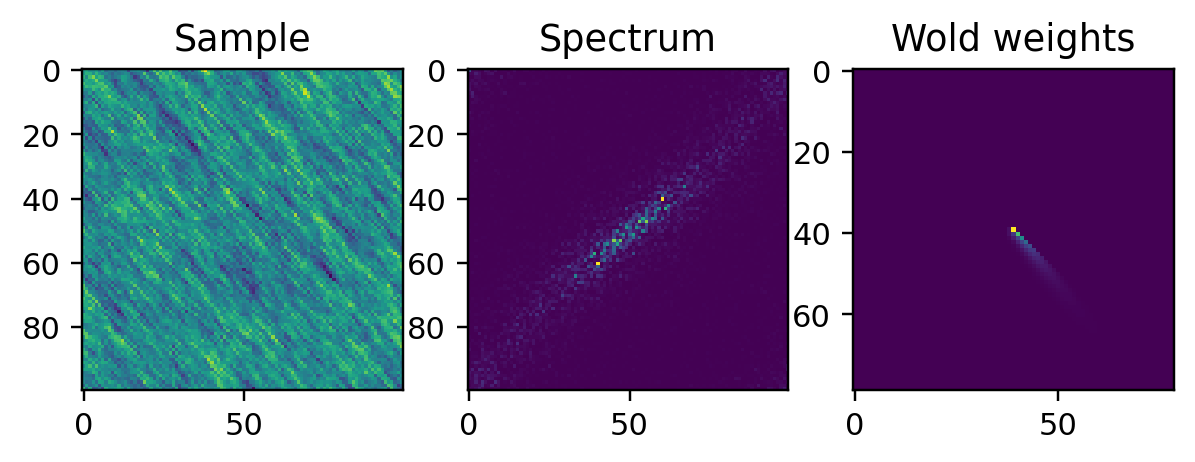

In [ ]:
def ar_to_half_gen(delta):
  return PlaneSampler(40, .04, .03, .8 - delta, delta)

def quarter_to_half(delta):
  PlaneSampler(40, .04, .03, .8 - delta, delta).plot()

quarter_to_half(.7)

In [84]:
sampler_AR_Q0 = ar_to_half_gen(.0)
rej_h1_AR_q_t_h = power_sim(sampler_AR_Q0, ar_to_half_gen, deltas)

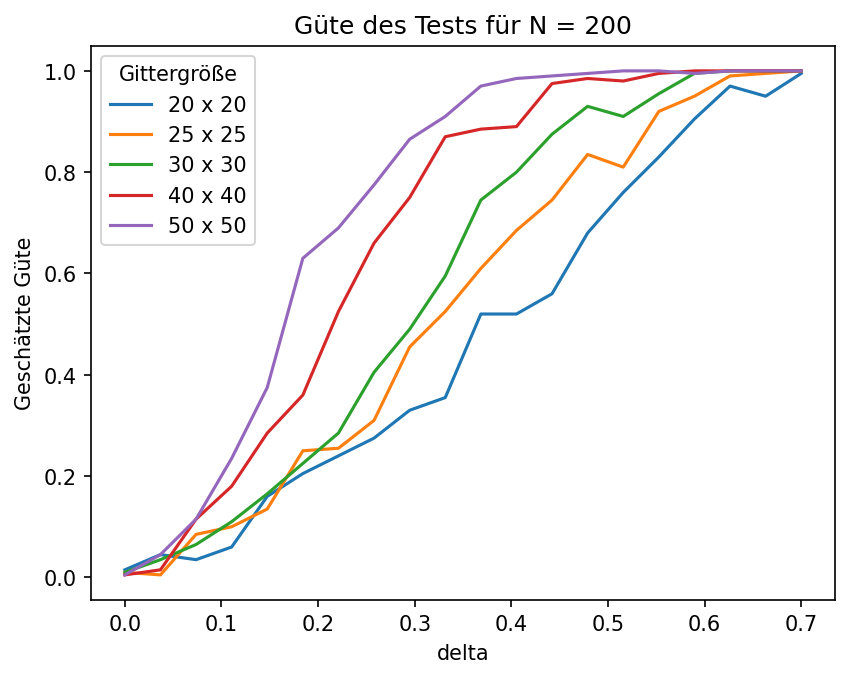

: 

In [ ]:
plot_power_result(rej_h1_AR_q_t_h, deltas)